#  1. Imports & Spark Setup

In [113]:
# %%
import os
import pandas as pd
import matplotlib.pyplot as plt
import holidays

import pyspark
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.functions import (
    col, date_trunc, hour, dayofweek, dayofmonth, month,
    count, to_timestamp, year, lit, expr, sequence, explode
)
from pyspark.sql.types import IntegerType

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## 1.1 Start Spark Session

In [119]:

# %%
spark = (
    SparkSession.builder
    .appName("NYC Taxi Forecast – 3Y with Weather")
    .config("spark.driver.memory", "8g")
    .config("spark.sql.shuffle.partitions", "50")
    .getOrCreate()
)

# 2. Load & Feature-Engineer Taxi Data

In [125]:
# 2.1 Load parquet and select timestamp
file_paths = [f for f in sorted(os.listdir(".")) if f.endswith(".parquet")]
df = spark.read.parquet(*file_paths).select("tpep_pickup_datetime")

In [127]:
# 2.2 Truncate to hour & extract calendar features
df = (
    df
    .withColumn("pickup_binned", date_trunc("hour", col("tpep_pickup_datetime")))
    .withColumn("hour", hour(col("pickup_binned")))
    .withColumn("day_of_week", dayofweek(col("pickup_binned")))
    .withColumn("day_of_month", dayofmonth(col("pickup_binned")))
    .withColumn("month", month(col("pickup_binned")))
    .withColumn("is_weekend", (col("day_of_week").isin([1,7])).cast(IntegerType()))
)


# 3. Aggregate & Enrich with Weather & Holidays

In [130]:
# 3.1 Hourly taxi counts
df_counts = df.groupBy("pickup_binned").agg(count("*").alias("order_count"))

In [132]:
# 3.2 One row per hour for the time features
df_timefeat = (
    df.select("pickup_binned", "hour", "day_of_week", "day_of_month", "month", "is_weekend")
      .dropDuplicates(["pickup_binned"])
)

In [134]:
# 3.3 Join counts + time features → ~26K rows
df_small = df_counts.join(df_timefeat, on="pickup_binned", how="left")


In [136]:
# 3.4 Load hourly weather CSV & parse timestamp
weather_path = "new york 2022-01-01 to 2024-12-31.csv"
df_weather = (
    spark.read.option("header", True).csv(weather_path)
    .withColumn("pickup_binned", to_timestamp(col("datetime"), "yyyy-MM-dd'T'HH:mm:ss"))
    .select("pickup_binned", "temp", "feelslike", "dew", "humidity", "precip", "precipprob", "snow")
)

In [138]:
# 3.5 Merge weather → still ~26K rows
df_enriched = df_small.join(df_weather, on="pickup_binned", how="left")

In [140]:
# 3.6 Add holiday flag via UDF on small table
us_h = holidays.US(years=[2022,2023,2024])
@F.udf(IntegerType())
def is_hol(dt):
    return 0 if dt is None else int(dt.date() in us_h)

df_enriched = df_enriched.withColumn("is_holiday", is_hol(col("pickup_binned")))

In [142]:
# 3.7 Filter only years 2022–2024
df_enriched = df_enriched.filter(year(col("pickup_binned")).isin(2022,2023,2024))

# 4. Fill Missing Hours & Rebuild Time-Features

In [145]:
# 4.1 Compute min/max and build a full-hour index
bounds = df_enriched.agg(
    F.min("pickup_binned").alias("start"),
    F.max("pickup_binned").alias("end")
).collect()[0]
start, end = bounds["start"], bounds["end"]

In [147]:
df_hours = (
    spark.range(1)
    .select(sequence(lit(start), lit(end), expr("interval 1 hour")).alias("all_hours"))
    .select(explode("all_hours").alias("pickup_binned"))
)


In [149]:
# 4.2 Left-join and refill order_count=0
df_full = df_hours.join(df_enriched, on="pickup_binned", how="left") \
    .fillna({"order_count": 0})

In [151]:
# 4.3 Recompute time features for any newly inserted hours
df_full = (
    df_full
    .withColumn("hour", hour(col("pickup_binned")))
    .withColumn("day_of_week", dayofweek(col("pickup_binned")))
    .withColumn("day_of_month", dayofmonth(col("pickup_binned")))
    .withColumn("month", month(col("pickup_binned")))
    .withColumn("is_weekend", (col("day_of_week").isin([1,7])).cast(IntegerType()))
)


# 5. Add Lag & Rolling-Window Features

In [154]:
w = Window.orderBy("pickup_binned")
w24  = w.rowsBetween(-24, -1)
w168 = w.rowsBetween(-168, -1)

In [156]:
df_feat = (
    df_full
    .withColumn("lag_1h",  F.lag("order_count", 1).over(w))
    .withColumn("lag_24h", F.lag("order_count", 24).over(w))
    .withColumn("roll24_mean", F.avg("order_count").over(w24))
    .withColumn("roll168_mean",F.avg("order_count").over(w168))
    .withColumn("roll24_std", F.stddev("order_count").over(w24))
)


In [158]:
# 5.1 Cache final features & materialize
df_feat = df_feat.coalesce(2).cache()
df_feat.count()

25/04/27 02:15:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/27 02:15:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/27 02:15:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/27 02:15:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/27 02:15:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/27 02:15:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/27 0

26310

# 6. To Pandas & Quick Cleaning

In [161]:
pdf = df_feat.orderBy("pickup_binned").toPandas()

In [163]:
# Convert weather cols to numeric
for c in ["temp","feelslike","dew","humidity","precip","precipprob","snow"]:
    pdf[c] = pd.to_numeric(pdf[c], errors="coerce")

In [165]:
# Clip any outliers by IQR (optional)
cols = ["order_count","temp","precip"]
for c in cols:
    Q1,Q3=pdf[c].quantile([0.25,0.75])
    IQR = Q3-Q1
    pdf[c] = pdf[c].clip(Q1-1.5*IQR, Q3+1.5*IQR)

# 7. Exploratory Plots

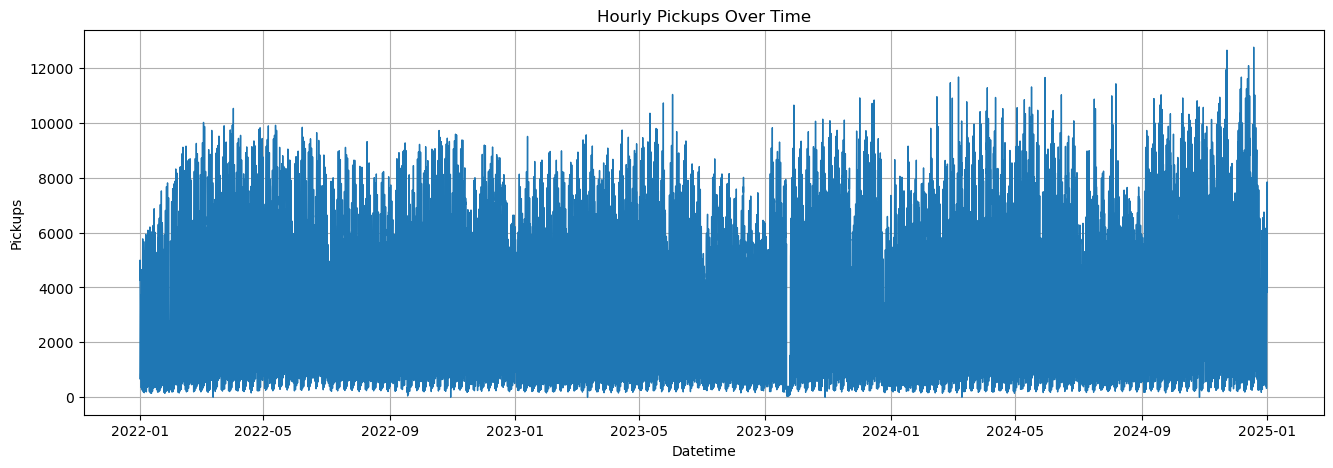

In [168]:
# 7.1 Overall hourly trend
plt.figure(figsize=(16,5))
plt.plot(pdf["pickup_binned"], pdf["order_count"], lw=1)
plt.title("Hourly Pickups Over Time")
plt.xlabel("Datetime"); plt.ylabel("Pickups"); plt.grid(True)
plt.show()

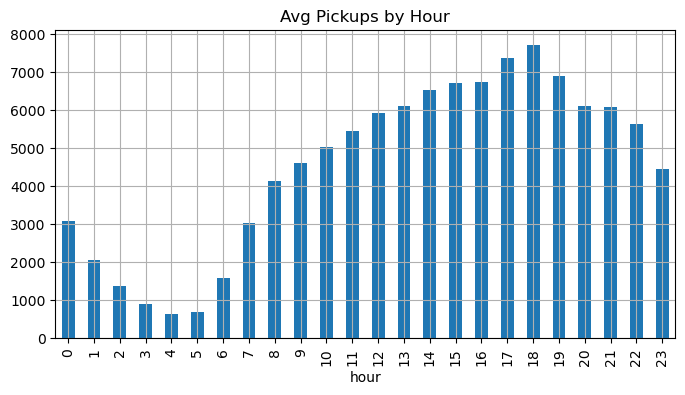

In [170]:
# 7.2 Avg by hour of day
plt.figure(figsize=(8,4))
pdf.groupby("hour")["order_count"].mean().plot(kind="bar")
plt.title("Avg Pickups by Hour"); plt.grid(True); plt.show()

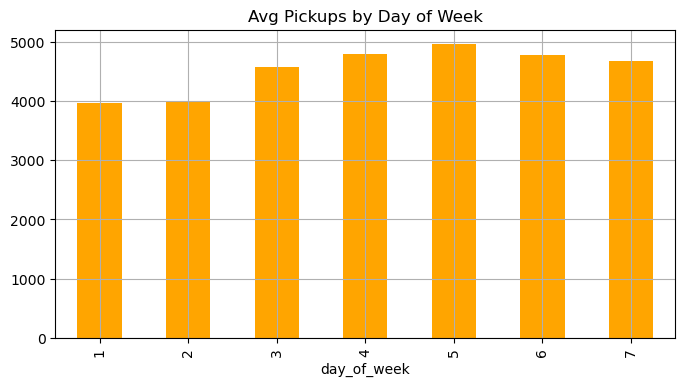

In [172]:
# 7.3 Avg by day of week
plt.figure(figsize=(8,4))
pdf.groupby("day_of_week")["order_count"].mean().plot(kind="bar", color="orange")
plt.title("Avg Pickups by Day of Week"); plt.grid(True); plt.show()

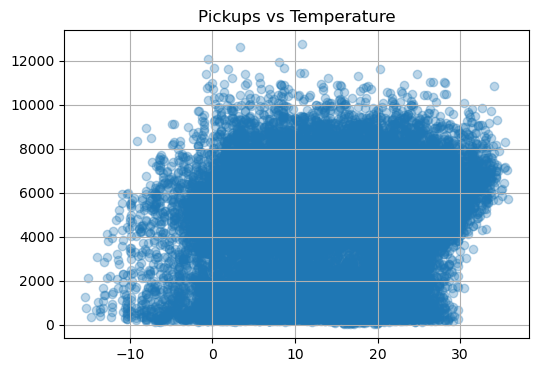

In [174]:
# 7.4 Pickups vs Temp
plt.figure(figsize=(6,4))
plt.scatter(pdf["temp"], pdf["order_count"], alpha=0.3)
plt.title("Pickups vs Temperature"); plt.grid(True); plt.show()

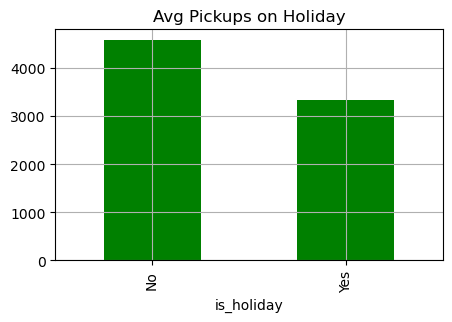

In [176]:
# 7.5 Holiday vs Non-Holiday
plt.figure(figsize=(5,3))
pdf.groupby("is_holiday")["order_count"].mean().plot(kind="bar", color="green")
plt.xticks([0,1],["No","Yes"]); plt.title("Avg Pickups on Holiday"); plt.grid(True); plt.show()


# 8. Train/Test Split & Feature Matrix

In [179]:
# %%
pdf = pdf.set_index("pickup_binned").sort_index()
cutoff = pd.Timestamp("2024-01-01 00:00:00")
train = pdf.loc[:cutoff - pd.Timedelta(hours=1)]
test  = pdf.loc[cutoff:]

In [181]:
FEATURES = [
    "hour","day_of_week","day_of_month","month","is_weekend","is_holiday",
    "temp","precip","lag_1h","lag_24h","roll24_mean","roll168_mean"
]
X_train, y_train = train[FEATURES], train["order_count"]
X_test,  y_test  = test[FEATURES],  test["order_count"]

# 9. Fit XGBoost & Evaluate

In [184]:
model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    objective="reg:squarederror", random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f} pickups/hr")

Test RMSE: 436.70 pickups/hr


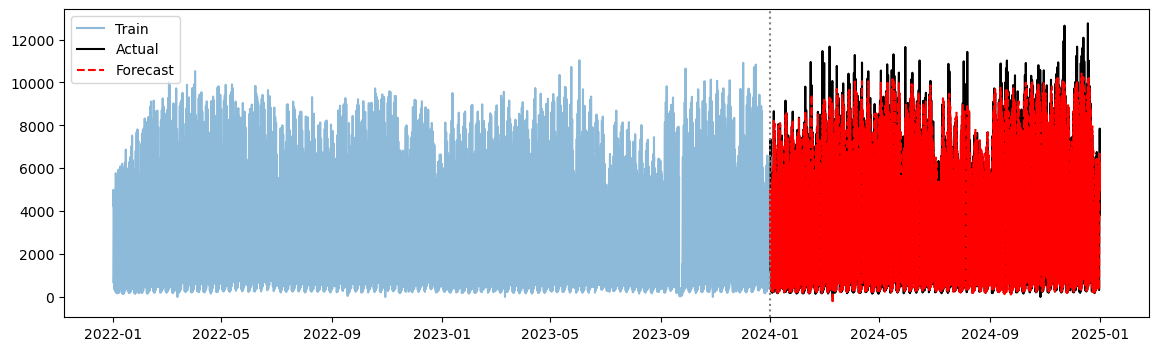

In [186]:
# Plot actual vs forecast
plt.figure(figsize=(14,4))
plt.plot(train.index, y_train, alpha=0.5, label="Train")
plt.plot(test.index,  y_test,  label="Actual", c="k")
plt.plot(test.index,  y_pred,  label="Forecast", c="r", ls="--")
plt.axvline(cutoff, c="gray", ls=":"); plt.legend(); plt.show()

## 9.1 Zoom January 2024

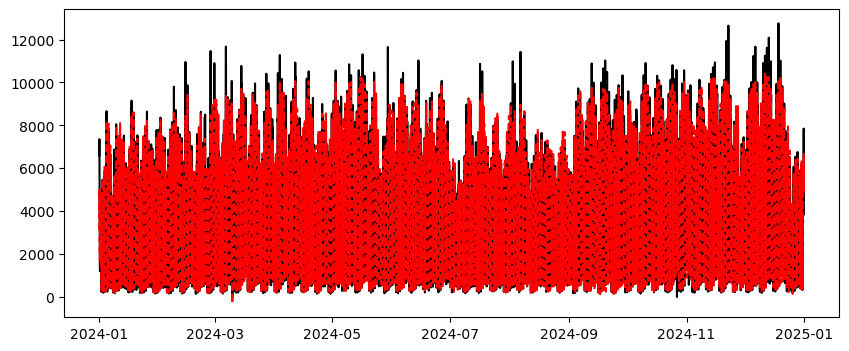

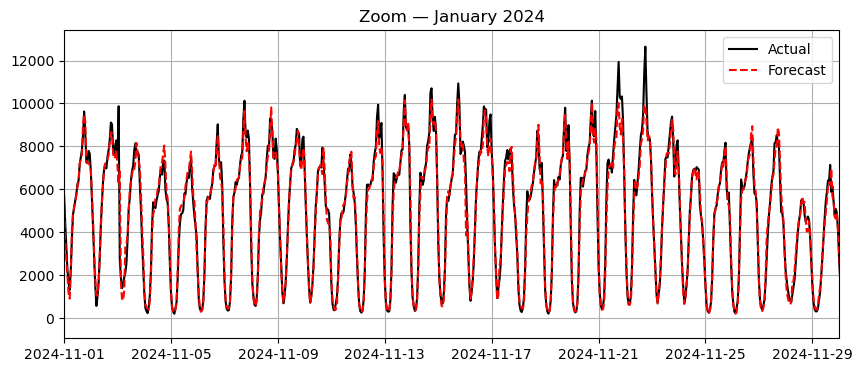

In [195]:
plt.figure(figsize=(10,4))
plt.plot(test.index, y_test, label="Actual", c="k")
plt.plot(test.index, y_pred, label="Forecast", c="r", ls="--")

plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2024-01-30"))

plt.title("Zoom — January 2024")
plt.legend()
plt.grid(True)
plt.show()

# 10. Train / Validation / Test Split

In [341]:
for col in ["temp", "dew", "humidity", "precip", "precipprob", "snow"]:
    pdf[col] = pd.to_numeric(pdf[col], errors="coerce")


In [297]:
# Definimos novos cortes de tempo
cutoff_train = pd.Timestamp("2023-07-01 00:00:00")
cutoff_test  = pd.Timestamp("2024-01-01 00:00:00")

In [299]:
# Separação
train_df = pdf.loc[:cutoff_train - pd.Timedelta(hours=1)]
valid_df = pdf.loc[cutoff_train:cutoff_test - pd.Timedelta(hours=1)]
test_df  = pdf.loc[cutoff_test:]

In [301]:
print("Train:", train_df.index.min(), "→", train_df.index.max(), "|", train_df.shape)
print("Valid:", valid_df.index.min(), "→", valid_df.index.max(), "|", valid_df.shape)
print("Test: ", test_df.index.min(),  "→", test_df.index.max(),  "|", test_df.shape)



Train: 2022-01-01 00:00:00 → 2023-06-30 23:00:00 | (13106, 19)
Valid: 2023-07-01 00:00:00 → 2023-12-31 23:00:00 | (4418, 19)
Test:  2024-01-01 00:00:00 → 2024-12-31 23:00:00 | (8786, 19)


In [303]:
# We already split into train (to 2023-06-30), valid (to 2023-12-31), test (2024).
# But let’s reassemble train+valid into one for hyperparameter tuning via PredefinedSplit.

# %%
# assume `pdf` is indexed by pickup_binned and sorted
cutoff_train = pd.Timestamp("2023-07-01 00:00:00")
cutoff_test  = pd.Timestamp("2024-01-01 00:00:00")

train_df = pdf.loc[:cutoff_train - pd.Timedelta(hours=1)]
valid_df = pdf.loc[cutoff_train:cutoff_test - pd.Timedelta(hours=1)]
test_df  = pdf.loc[cutoff_test:]

# Combine train+valid for GridSearchCV
tv_df = pd.concat([train_df, valid_df])
X_tv = tv_df[FEATURES]
y_tv = tv_df["order_count"]

for c in X_tv.columns:
    X_tv[c] = pd.to_numeric(X_tv[c], errors="coerce")

# Create PredefinedSplit: -1 for train rows, 0 for valid rows
test_fold = np.concatenate([
    np.full(len(train_df), -1, dtype=int),
    np.zeros(len(valid_df), dtype=int)
])
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

print("TV shape:", X_tv.shape, "TestSplit:", ps.get_n_splits())

TV shape: (17524, 12) TestSplit: 1


/var/folders/2w/6dnd6yrd33s7jvq3758g16fm0000gn/T/ipykernel_8441/2085517464.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tv[c] = pd.to_numeric(X_tv[c], errors="coerce")


In [343]:
# 7. Construir matrizes X/y
X_train = train_df[FEATURES]
y_train = train_df["order_count"]

X_valid = valid_df[FEATURES]
y_valid = valid_df["order_count"]

X_test  = test_df[FEATURES]
y_test  = test_df["order_count"]

X_tv    = tv_df[FEATURES]
y_tv    = tv_df["order_count"]

# 8. Safety: converter todas features para numéricas
for df in [X_tv, X_test, X_train, X_valid]:
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

/var/folders/2w/6dnd6yrd33s7jvq3758g16fm0000gn/T/ipykernel_8441/865575478.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors="coerce")


In [345]:
test_fold = np.concatenate([
    np.full(len(train_df), -1, dtype=int),  # -1 para treino
    np.zeros(len(valid_df), dtype=int)      # 0 para validação
])

ps = PredefinedSplit(test_fold)

# Check
print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape, "Test shape:", X_test.shape)
print("TV shape:", X_tv.shape, "PredefinedSplit folds:", ps.get_n_splits())

Train shape: (13106, 12) Valid shape: (4418, 12) Test shape: (8786, 12)
TV shape: (17524, 12) PredefinedSplit folds: 1


# 11. Hyperparameter Tuning: XGBoost via PredefinedSplit

In [347]:
from sklearn.model_selection import GridSearchCV

In [349]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

param_grid_xgb = {
    "n_estimators": [200, 500],
    "max_depth":    [4, 6, 8],
    "learning_rate":[0.01, 0.05],
    "subsample":    [0.7, 0.9],
    "colsample_bytree":[0.7, 0.9]
}


In [351]:
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=ps,
    scoring="neg_root_mean_squared_error",
    verbose=2
)

In [353]:
grid_xgb.fit(X_tv, y_tv)
print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB CV RMSE:", -grid_xgb.best_score_)


Fitting 1 folds for each of 48 candidates, totalling 48 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.9; total time=   0.4s
[CV] END co

# 12. Hyperparameter Tuning: LightGBM via PredefinedSplit

In [355]:
from lightgbm import LGBMRegressor


In [356]:
lgb = LGBMRegressor(objective="regression", random_state=42, n_jobs=-1)

param_grid_lgb = {
    "n_estimators": [200, 500],
    "max_depth":    [4, 6, 8],
    "learning_rate":[0.01, 0.05],
    "subsample":    [0.7, 0.9],
    "colsample_bytree":[0.7, 0.9]
}

grid_lgb = GridSearchCV(
    estimator=lgb,
    param_grid=param_grid_lgb,
    cv=ps,
    scoring="neg_root_mean_squared_error",
    verbose=2
)

In [357]:
grid_lgb.fit(X_tv, y_tv)
print("Best LGB params:", grid_lgb.best_params_)
print("Best LGB CV RMSE:", -grid_lgb.best_score_)

Fitting 1 folds for each of 48 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 13106, number of used features: 11
[LightGBM] [Info] Start training from score 4515.003128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

# 13. Hyperparameter Tuning: CatBoost via PredefinedSplit

In [359]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

param_grid_cb = {
    "iterations":    [200, 500],
    "depth":         [4, 6, 8],
    "learning_rate": [0.01, 0.05]
}

grid_cb = GridSearchCV(
    estimator=cb,
    param_grid=param_grid_cb,
    cv=ps,
    scoring="neg_root_mean_squared_error",
    verbose=2
)

In [360]:
grid_cb.fit(X_tv, y_tv)
print("Best CB params:", grid_cb.best_params_)
print("Best CB CV RMSE:", -grid_cb.best_score_)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ........depth=4, iterations=200, learning_rate=0.01; total time=   0.2s
[CV] END ........depth=4, iterations=200, learning_rate=0.05; total time=   0.2s
[CV] END ........depth=4, iterations=500, learning_rate=0.01; total time=   0.4s
[CV] END ........depth=4, iterations=500, learning_rate=0.05; total time=   0.4s
[CV] END ........depth=6, iterations=200, learning_rate=0.01; total time=   0.3s
[CV] END ........depth=6, iterations=200, learning_rate=0.05; total time=   0.3s
[CV] END ........depth=6, iterations=500, learning_rate=0.01; total time=   0.6s
[CV] END ........depth=6, iterations=500, learning_rate=0.05; total time=   0.6s
[CV] END ........depth=8, iterations=200, learning_rate=0.01; total time=   0.4s
[CV] END ........depth=8, iterations=200, learning_rate=0.05; total time=   0.4s
[CV] END ........depth=8, iterations=500, learning_rate=0.01; total time=   1.0s
[CV] END ........depth=8, iterations=500, learni

# 14. Final Evaluation on Test Set

In [370]:
# Choose best model by CV RMSE
best_models = {
    "XGB": (grid_xgb.best_estimator_, -grid_xgb.best_score_),
    "LGB": (grid_lgb.best_estimator_, -grid_lgb.best_score_),
    "CatB":(grid_cb.best_estimator_, -grid_cb.best_score_)
}

In [372]:
for name,(mdl,cv_rmse) in best_models.items():
    y_pred = mdl.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"{name}: CV RMSE={cv_rmse:.1f}, Test RMSE={test_rmse:.1f}")

XGB: CV RMSE=327.8, Test RMSE=433.5
LGB: CV RMSE=325.8, Test RMSE=423.4
CatB: CV RMSE=339.7, Test RMSE=420.3


# 15. Plot Best Forecast vs Actual

In [375]:
best_name, (best_mdl, _) = min(best_models.items(), key=lambda x: x[1][1])
y_best = best_mdl.predict(X_test)

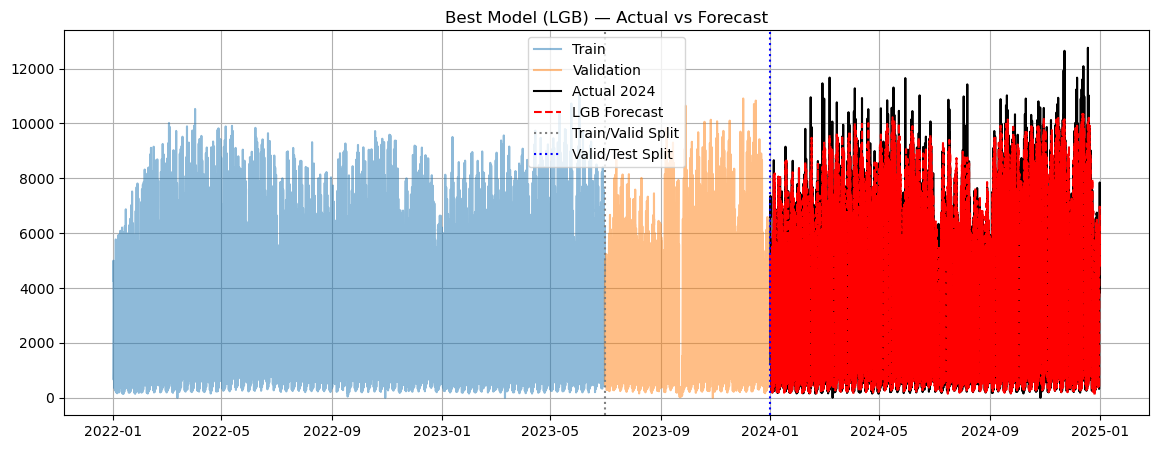

In [377]:
plt.figure(figsize=(14,5))
plt.plot(train_df.index, train_df["order_count"], alpha=0.5, label="Train")
plt.plot(valid_df.index, valid_df["order_count"], alpha=0.5, label="Validation")
plt.plot(test_df.index,  y_test,  label="Actual 2024", color="black")
plt.plot(test_df.index,  y_best,  label=f"{best_name} Forecast", color="red", ls="--")
plt.axvline(cutoff_train, color="gray", ls=":", label="Train/Valid Split")
plt.axvline(cutoff_test,  color="blue", ls=":", label="Valid/Test Split")
plt.legend()
plt.title(f"Best Model ({best_name}) — Actual vs Forecast")
plt.grid(True)
plt.show()

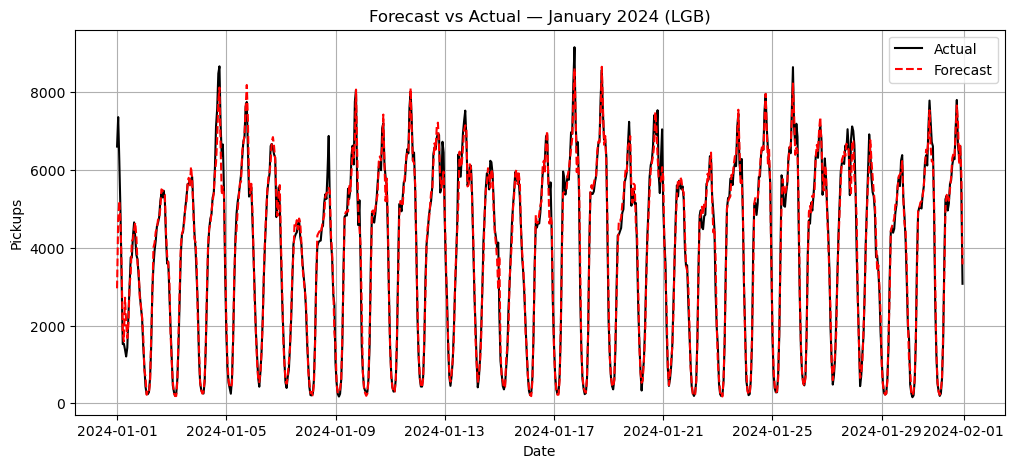

In [379]:
plt.figure(figsize=(12,5))
plt.plot(test_df.loc["2024-01-01":"2024-01-31"].index, y_test.loc["2024-01-01":"2024-01-31"], label="Actual", color="black")
plt.plot(test_df.loc["2024-01-01":"2024-01-31"].index, y_best[test_df.index.get_loc("2024-01-01 00:00:00"):test_df.index.get_loc("2024-01-31 23:00:00")+1], label="Forecast", color="red", linestyle="--")
plt.title(f"Forecast vs Actual — January 2024 ({best_name})")
plt.xlabel("Date")
plt.ylabel("Pickups")
plt.legend()
plt.grid(True)
plt.show()